## SNAP Exploration of Autocorrelated Noise

Demo how autocorrelation (1/f exponent) relates to slow ramping signals

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import pandas as pd
import seaborn as sns
from scipy.io import loadmat,savemat
from scipy.signal import deconvolve, savgol_filter

!pip install colorednoise
import colorednoise as cn

from sklearn.linear_model import LogisticRegression

from scipy.spatial import KDTree
from scipy.ndimage.interpolation import shift

import statsmodels.api as sm


from utils import *

savepath = './figures/model_preds/'

In [2]:
## Demo w/ colored noise package



In [3]:
n_sims = 100
tsteps = 20000

X = np.zeros((n_sims,tsteps))
# noise = np.random.randn(n_sims,tsteps)
noise = cn.powerlaw_psd_gaussian(0.1, (n_sims,tsteps))

slopes = np.random.rand(n_sims,)*0.2 # slope

# Simulation Parameters from Schurger, Sitt, & Dehaene (2012)
k = 0.5 # leak
I = 0.11 # urgency/drift
# I = 0.2
B = 0.298 # threshold
c = 0.1 # noise scaling
dt = 0.001 # time increment




for tt in range(tsteps-1):
    
    # Stochastic Accumulator & Pink Noise Accumulator
    deltaX = c * noise[:,tt] 
    
    # Linear Ballistic Accumulator
#     if tt < 1500: continue
#     deltaX =  slopes*dt + c * noise[:,tt] * np.sqrt(dt) 
    
    X[:,tt+1] = X[:,tt] + deltaX
    
    # Stop updating if >= B
    if np.any(X[:,tt+1]) >= B:
        X[np.where(X[:,tt+1]>=B),tt+1] = B

In [4]:
first_tx = np.zeros(n_sims)
backwards = np.zeros((n_sims,3000))
backwards_noise = np.zeros((n_sims,3000))

for ii in range(n_sims):
    if np.any(np.where(X[ii,:]>=B)):
        first_tx[ii] = np.where(X[ii,:]>=B)[0][0]
        
        if first_tx[ii] > 3000:
            backwards[ii,:] = X[ii,int(first_tx[ii]-3000):int(first_tx[ii])]
            backwards_noise[ii,:] = noise[ii,int(first_tx[ii]-3000):int(first_tx[ii])]

        else:
            backwards[ii,:] = np.nan
            backwards_noise[ii,:] = np.nan
    else:
        first_tx[ii] = np.nan
        backwards[ii,:] = np.nan

/var/folders/yf/4w_d87yd2839wcjcx53kmbn40000gn/T/ipykernel_8206/3138509912.py:11: RuntimeWarning: Mean of empty slice
  backwards_baselined = (backwards.T - np.nanmean(backwards[:,1:1000],1))*-1
/var/folders/yf/4w_d87yd2839wcjcx53kmbn40000gn/T/ipykernel_8206/3138509912.py:12: RuntimeWarning: Mean of empty slice
  backwards_baselined_noise = (backwards_noise.T - np.nanmean(backwards_noise[:,1:1000],1))*-1


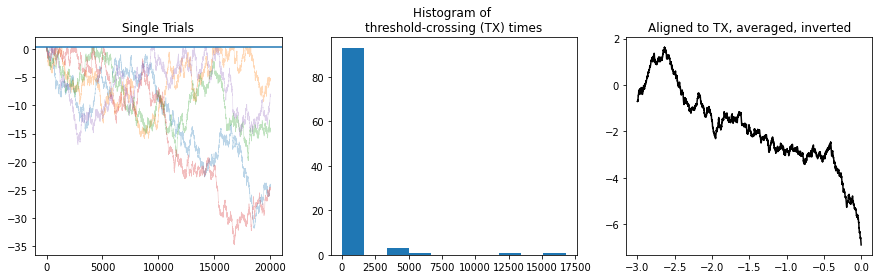

In [5]:
fig,ax = plt.subplots(1,3,figsize=(15,4))


ax[0].plot(np.arange(tsteps),X[:5,:].T,lw=0.5,alpha=0.3)
ax[0].axhline(B)
ax[0].set_title('Single Trials')

ax[1].hist(first_tx)
ax[1].set_title('Histogram of \nthreshold-crossing (TX) times')

backwards_baselined = (backwards.T - np.nanmean(backwards[:,1:1000],1))*-1
backwards_baselined_noise = (backwards_noise.T - np.nanmean(backwards_noise[:,1:1000],1))*-1
ax[2].plot(np.linspace(-3,0,backwards.shape[1]),np.nanmean(backwards_baselined.T,0),'k')
ax[2].set_title('Aligned to TX, averaged, inverted')

plt.savefig(savepath+'autocorr_demo.svg',bbox_inches='tight')
plt.savefig(savepath+'autocorr_demo.png',bbox_inches='tight')

plt.show()

In [6]:
noise.shape

(100, 20000)

In [7]:
np.cumsum(noise,1).shape

(100, 20000)

In [8]:
n_sims = 1000
tsteps = 20000


# noise = np.random.randn(n_sims,tsteps)


beta = 0.5
# Simulation Parameters from Schurger, Sitt, & Dehaene (2012)
k = 0.5 # leak
I = 0.11 # urgency/drift
# I = 0.2
B = 0.3 # threshold
c = 0.1 # noise scaling
dt = 0.001 # time increment


X = cn.powerlaw_psd_gaussian(beta, (n_sims,tsteps)) * c


first_tx = np.zeros(n_sims)
backwards = np.zeros((n_sims,3000))

for ii in range(n_sims):
    if np.any(np.where(X[ii,:]>=B)):
        first_tx[ii] = np.where(X[ii,:]>=B)[0][0]
        
        if first_tx[ii] > 3000:
            backwards[ii,:] = X[ii,int(first_tx[ii]-3000):int(first_tx[ii])]
            
        else:
            backwards[ii,:] = np.nan
    else:
        first_tx[ii] = np.nan
        backwards[ii,:] = np.nan

/var/folders/yf/4w_d87yd2839wcjcx53kmbn40000gn/T/ipykernel_14338/4051737918.py:5: RuntimeWarning: Mean of empty slice
  backwards_baselined = (backwards.T - np.nanmean(backwards[:,1:1000],1))


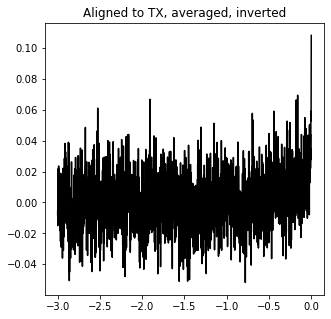

In [9]:
fig = plt.figure(figsize=(5,5))

ax = plt.gca()

backwards_baselined = (backwards.T - np.nanmean(backwards[:,1:1000],1))


ax.plot(np.linspace(-3,0,backwards.shape[1]),np.nanmean(backwards_baselined.T,0),'k')
ax.set_title('Aligned to TX, averaged, inverted')

plt.savefig(savepath+'autocorr_demo.svg',bbox_inches='tight')
plt.savefig(savepath+'autocorr_demo.png',bbox_inches='tight')

plt.show()

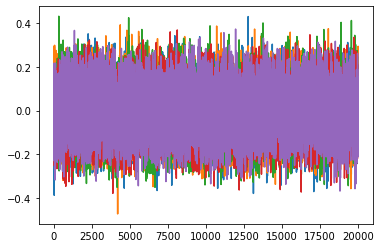

In [10]:
plt.plot(np.arange(tsteps),X[:5,:].T)

In [16]:
n_sims = 10000
tsteps = 20000


# noise = np.random.randn(n_sims,tsteps)


betas = np.arange(0.5,2.6,0.1)

# Simulation Parameters from Schurger, Sitt, & Dehaene (2012)
k = 0.5 # leak
I = 0.11 # urgency/drift
# I = 0.2
B = 0.3 # threshold
c = 0.1 # noise scaling
dt = 0.001 # time increment

BA = np.zeros((len(betas),3000))

X_ex = np.zeros((n_sims,tsteps))

for jj,beta in enumerate(betas):
    X = cn.powerlaw_psd_gaussian(beta, (n_sims,tsteps)) * c


    first_tx = np.zeros(n_sims)
    backwards = np.zeros((n_sims,3000))

    for ii in range(n_sims):
        if np.any(np.where(X[ii,:]>=B)):
            first_tx[ii] = np.where(X[ii,:]>=B)[0][0]

            if first_tx[ii] > 3000:
                backwards[ii,:] = X[ii,int(first_tx[ii]-3000):int(first_tx[ii])]

            else:
                backwards[ii,:] = np.nan
        else:
            first_tx[ii] = np.nan
            backwards[ii,:] = np.nan
            
    
    backwards_baselined = (backwards.T - np.nanmean(backwards[:,1:1000],1)) 
    BA[jj,:] = np.nanmean(backwards_baselined.T,0)
    
    
    X_ex[jj,:] = X[0,:]
    
        
    

/var/folders/yf/4w_d87yd2839wcjcx53kmbn40000gn/T/ipykernel_8206/1846766599.py:43: RuntimeWarning: Mean of empty slice
  backwards_baselined = (backwards.T - np.nanmean(backwards[:,1:1000],1))


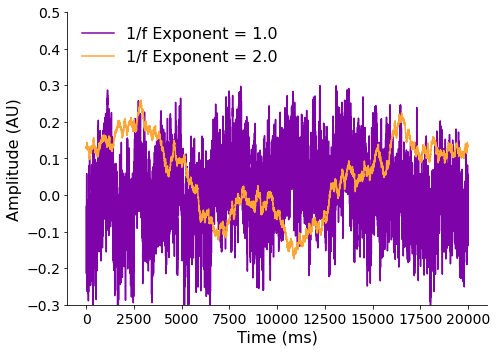

In [34]:
X_ex[X_ex > B] = np.nan

fig, ax = plt.subplots(figsize=(7,5))

x = np.linspace(-3,0,backwards.shape[1])

y = BA.T


colormap = plt.cm.plasma #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1,BA.shape[0])]

ax.plot(X_ex[5,:],color=colors[5],label='1/f Exponent = 1.0')
ax.plot(X_ex[len(betas)-5,:],color=colors[-5],label='1/f Exponent = 2.0')

ax.legend(loc='upper left',fontsize=16,frameon=False)

# cb = fig.colorbar(sm)
# ax.set_clim(0,21)

# cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().height*0.3,0.02,ax.get_position().height*0.7])
# plt.colorbar(line, cax=cax) # Similar to fig.colorbar(im, cax = cax)

# ax.set_xlim(-3,0)
ax.set_ylim(-0.3,0.5)

plt.xlabel('Time (ms)',fontsize=16)
plt.ylabel('Amplitude (AU)',fontsize=16)
plt.tight_layout()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_xticks(np.arange(-3,0.1,0.5))
# ax.set_yticks(np.arange(0.25,1.1,0.25))
ax.tick_params(labelsize=14)


# ax.view_init(20, 35)



fig.tight_layout()

plt.savefig(savepath+'autocorr_ex.svg',bbox_inches='tight')
plt.savefig(savepath+'autocorr_ex.png',bbox_inches='tight')


plt.show()

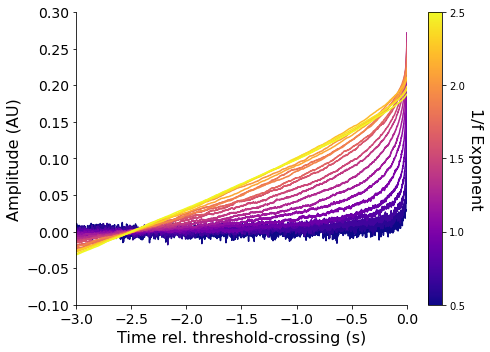

In [33]:
fig, ax = plt.subplots(figsize=(7,5))

x = np.linspace(-3,0,backwards.shape[1])

y = BA.T


colormap = plt.cm.plasma #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1,BA.shape[0])]

norm = plt.Normalize(0, BA.shape[0])
lc = LineCollection([np.column_stack([x,BA[i,:]]) for i in range(BA.shape[0])],color=colors,norm=norm)

# lc.set_array(x)

line = ax.add_collection(lc)

sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
cb = plt.colorbar(sm,ticks=np.linspace(0,21,5))
cb.ax.set_yticklabels(['0.5', '1.0', '1.5', '2.0', '2.5'])
cb.ax.get_yaxis().labelpad = 18
cb.ax.set_ylabel('1/f Exponent', rotation=270,fontsize=16)


# cb = fig.colorbar(sm)
# ax.set_clim(0,21)

# cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().height*0.3,0.02,ax.get_position().height*0.7])
# plt.colorbar(line, cax=cax) # Similar to fig.colorbar(im, cax = cax)

ax.set_xlim(-3,0)
ax.set_ylim(-0.1,0.3)

plt.xlabel('Time rel. threshold-crossing (s)',fontsize=16)
plt.ylabel('Amplitude (AU)',fontsize=16)
plt.tight_layout()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(np.arange(-3,0.1,0.5))
# ax.set_yticks(np.arange(0.25,1.1,0.25))
ax.tick_params(labelsize=14)


# ax.view_init(20, 35)



fig.tight_layout()

plt.savefig(savepath+'autocorr_demo.svg',bbox_inches='tight')
plt.savefig(savepath+'autocorr_demo.png',bbox_inches='tight')


plt.show()